# Project waitingTimePrediction changed to nbOfTick within frame prediction

Disclaimer: 

CPU : i7-7700k - 4.5Ghz Overclocked

GPU : Nvidia 1080ti

RAM : 32Go

SSD : 2X250Go

No issue of memory with this configuration
The Data itself, weights more than 2To uncompressed. 

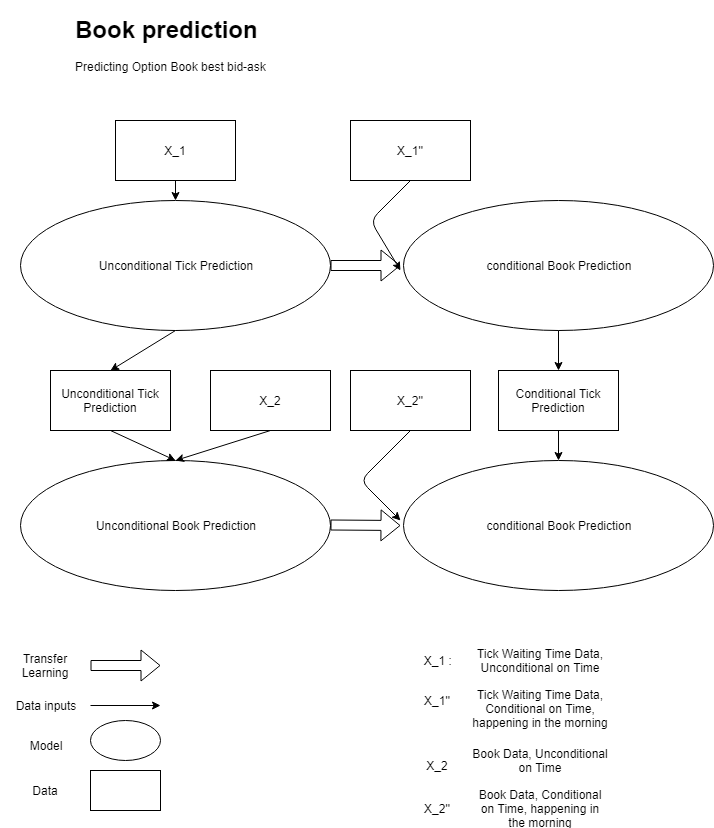

In [1]:
from IPython.display import display, Image

i = Image(filename="ModelThesis.png")
display(i)

In [2]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path
# import L4.L4 as L4

# from pandas.plotting import parallel_coordinates
# from sklearn.mixture import GaussianMixture as GMM
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [3]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [4]:

def getExpiryDate(aBook):
    anExpiryCode  = aBook[6:8]
    #hardcoded version for now. 
    myString_date = ''
    
    myString_year = ''
    myString_month = ''
    myString_day = ''
    
    #get year code
    if anExpiryCode[0] == 'L':
        myString_year = "2016"
    elif anExpiryCode[0] == 'M':
        myString_year = "2017"
    elif anExpiryCode[0] == 'N':
        myString_year = "2018"
    elif anExpiryCode[0] == 'P': #It looks strange, but that's KRX 
        myString_year = "2019"
    else : 
        sys.stderr.write("fatal error\n expiry year code unknown \n")
    
    #get month code
    myPotentialMonths = ['','1','2','3','4','5','6','7','8','9','A','B','C']

    if anExpiryCode[1] in myPotentialMonths:
        myString_month =  str(myPotentialMonths.index(anExpiryCode[1]))
    else : 
        sys.stderr.write("fatal error\n expiry month code unknown \n")    
    
    if myString_month == '':
        sys.stderr.write("fatal error\n expiry month code unknown \n")   
    #get day
    #get third Wednesday of every month, we will have to make bank holidays exceptions
    myString_day = str(calendar.Calendar(2).monthdatescalendar(int(myString_year), \
                                                               int(myString_month))[3][0].day)
    
#     print(myString_month)                   
    myString_date = myString_year+'-'+myString_month+'-'+myString_day+' 16:00:00'

    timeZone = tz.gettz('Asia/Seoul')
            
    #print("Don't forget bank holidays exceptions")
    return datetime.strptime(myString_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timeZone).astimezone(timeZone)


In [5]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

# Load Data

In [13]:
def inStrikeRange(aFutBook, aOptBook):
    '''
    look at slightly OTM or ITM options and keep that range static. Change dynamically book to keep that range
    '''
    if aFutBook == '' or aOptBook == '': #if the fut book is not itialized
        return False
    elif getBookContract(aOptBook[8:11],aOptBook[3]) is not CONTRACTTYPE.CALL : #only if Call
        return False
    
    return ((int(aOptBook[8:11]) > int(5 * np.floor((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))-5 )
    and (int(aOptBook[8:11]) < int(5 * np.ceil((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))+11))

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    '''
    aOptionStrike: enables to initialize the book to start with
    '''
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    myFutPrice = 0
    myDTM = -1 #dayToMaturity
    
    myFirstFut = True
    myFirstOpt = True
    myFirstOptionTick =True
    myFutBook = ''
    myFutTick = ''
    myOptionBook = ''
    myPastOptionBook = ''
    myTimeList = [] #faster than nparray for appending
    myYTimeList = []
    
    myTimeListFut = []

    
    myBidAskBook = []
    myBidAskBookFut = []
    
    myYBidAskBook = []
    
    myUpperCounter = -1 #future prediction
    myLowerCounter = 0
    
    Ys = [] #to predict
    YBook = [] # to predict 
    
    myIniSecondsFut = 0
    
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        
        if myBook[5] == '1':   #it as to be a MAXI
            
            myTickCreatedTime = tick['created']/1000000 #vastly reused in the code
            TTM = (getExpiryDate(myBook) - utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))).total_seconds()/3600/24    
#             test.append(TTM)
#             print(getBookContract(myBook[8:11],myBook[3]))
#             print(TTM)


            if(getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE) and TTM<90 :
#                 print('1')
                if tick['type']=='lastdone' : 
#                     print('2')
                    if myFirstFut:
                        myFutBook = myBook
                        myFirstFut = False
                        myIniSecondsFut = np.floor(myTickCreatedTime)

                    if myFutBook == myBook:
                        myLastVolFut = (0.995*myLastVol + 0.001*(tick['volume']))
                        timeOfTradeFut = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myFutPrice = tick['price']
                        
                else:
                    
                    myFutTick = tick
       
                                
                                
            if not myFirstFut and inStrikeRange(myFutTick, myBook) and (myDTM==np.floor(TTM) or myDTM==-1) and TTM<30: #this also checks if is CALL
#                 print('3')
                    #we need to go through a first future to calculate the moneyness
                    #range we accept to look at a product (keep it not too small or it will always change book)
                myFutMid = (myFutTick['bid_price_0']+ myFutTick['ask_price_0'])/2
                #check for not initialized book or if not in range book
                if np.isnan(aOptionStrike) or not inStrikeRange(myFutTick, myOptionBook) :
                    aOptionStrike = int(5 * np.ceil(myFutMid/5))
                
                if tick['type']=='lastdone' and myBook[8:11]==str(aOptionStrike):

                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myDTM = np.floor(TTM)

#                     if myOptionBook == myBook:   
                    myLastVol = (0.995*myLastVol + 0.0007*(tick['volume']))
                    timeOfTrade = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
        
                if tick['type']=='tick'  and myBook[8:11]==str(aOptionStrike):
#                     print('4')
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False

                        
                    if myFirstOptionTick:
                        myPastOptionBook = tick
                        myFirstOptionTick = False
                        myIniSeconds = np.floor(myTickCreatedTime)
                        myOldTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myDTM = np.floor(TTM)
                    #only interested in first 2 levels  
                    
                    if (tick['ask_volume_0'] != myPastOptionBook['ask_volume_0']) or \
                        (tick['ask_volume_1'] != myPastOptionBook['ask_volume_1']) or \
                        (tick['bid_volume_0'] != myPastOptionBook['bid_volume_0']) or \
                        (tick['bid_volume_1'] != myPastOptionBook['bid_volume_1']):
#                         print(aOptionStrike, myFutMid)                    
#                         print('5')




                        #calculate interesting past for Future

                        
                        myTimeListFut.append(myTickCreatedTime-myIniSecondsFut)
                        myBidAskBookFut.append([float(myFutTick['bid_volume_1']),float(myFutTick['bid_volume_0']),
                                                float(myFutTick['ask_volume_0']),float(myFutTick['ask_volume_1']),

                                               float(myFutTick['bid_price_1']),float(myFutTick['bid_price_0']),
                                                float(myFutTick['ask_price_0']),float(myFutTick['ask_price_1'])
                                              ]) 






                        #CALCULATE INTERESTING PAST FOR OPTION:



                        myPastOptionBook = tick
                        
                        
                        currTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                            #keep in mind the time second per sec
                        
                        myTimeList.append(myTickCreatedTime-myIniSeconds)
                        myYTimeList.append(myTickCreatedTime-myIniSeconds)
                        
                        myBidAskBook.append([float(tick['bid_volume_1']),float(tick['bid_volume_0']),
                                            float(tick['ask_volume_0']),float(tick['ask_volume_1']),
                                           
                                           float(tick['bid_price_1']),float(tick['bid_price_0']),
                                            float(tick['ask_price_0']),float(tick['ask_price_1'])
                                             ])
                        myYBidAskBook.append([float(myFutTick['bid_volume_0']),
                                                float(myFutTick['ask_volume_0']),

                                               float(myFutTick['bid_price_0']),
                                                float(myFutTick['ask_price_0'])
                                              ]) 
                                           
                        myCounter += 1
                        
 
                        #Using a ring buffer wouldn't work ... so :
                        myC3=0
                        myC1=0
                        myC05=0
                        myC025=0
                        myC01=0
                        myIdxToStartForClean=0
                        myBook1sFut = [np.NaN for x in range(0,8)]
                        myBookdot25sFut = [np.NaN for x in range(0,8)]
                        myBookdot1sFut = [np.NaN for x in range(0,8)]
                        myBookdot1s = [np.NaN for x in range(0,8)]
                        myBookdot5s = [np.NaN for x in range(0,8)]
                        
                        for idx,dtStart in enumerate(myTimeList): #I know, could do better
                            dtRecent = myTimeList[-1] - dtStart
                            dtRecentFut = myTimeListFut[-1] - dtStart
#                             print(myBidAskBook[-1])
                            bookFutDiffInPerc = [(myBidAskBookFut[-1][idx2]+0.01)/(x+0.01)-1 for idx2,x in enumerate(myBidAskBookFut[idx])]
                            bookDiffInPerc = [(myBidAskBook[-1][idx2]+0.01)/(x+0.01)-1 for idx2,x in enumerate(myBidAskBook[idx])]
#                             print('passed1')
                            if dtRecent>=3:
                                myIdxToStartForClean = idx
                                myBook1sFut = bookFutDiffInPerc
                            if dtRecent<3:
                                myC3 +=1
                            if dtRecent<1:
                                myC1 +=1
                                if dtRecent>0.5:
                                    myBookdot5s = bookDiffInPerc  #will store the book change that occured just before .5s ago
                            if dtRecent<0.5:
                                myC05 +=1 
                                if dtRecent>0.25:
                                    myBookdot25sFut = bookFutDiffInPerc
                            if dtRecent<0.25:
                                myC025 +=1 
                                if dtRecent>0.1:
                                    myBookdot1s = bookDiffInPerc #will store the book change that occured just before .1s
                                    myBookdot1sFut = bookFutDiffInPerc
                            if dtRecent<0.1:
                                myC01 +=1
                            if dtRecent<0:
                                print("issue, dt<0")
#                         print(myBookdot1s)        
                        myTimeList = myTimeList[myIdxToStartForClean:] #clean the list
                        myBidAskBook = myBidAskBook[myIdxToStartForClean:]
                        

                       #future information:
                        myTimeListFut =   myTimeListFut[myIdxToStartForClean:]          
                        myBidAskBookFut =    myBidAskBookFut[myIdxToStartForClean:]  
                        
                        
                        #it can sometimes jump some fraction of a second and leave a NaN, so correct:
                        if np.isnan(myBook1sFut).any():
                            myBook1sFut = [0 for x in range(0,8)]
                        if np.isnan(myBookdot25sFut).any():
                            myBookdot25sFut = myBook1sFut
                        if np.isnan(myBookdot1sFut).any():
                            myBookdot1sFut = myBookdot25sFut
                        if np.isnan(myBookdot1s).any():
                            myBookdot1s = [0 for x in range(0,8)]
                        if np.isnan(myBookdot5s).any():
                            myBookdot5s = myBookdot1s                       
                        
                        
                        try:
#                             print('passed3')
#                             print(myBook1sFut,myBookdot25sFut,myBookdot1sFut,myBookdot5s,myBookdot1s)
                            timeOfDay = currTime.hour \
                                        +currTime.minute/60
                                
                            moneyness = 2*myFutMid/int(myOptionBook[8:11])
                            
                            if len(myTicksOfInterest) == 0 :
                                myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                    15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                                    40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                                    TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01,\
                                                                    myBook1sFut[0],myBook1sFut[1],myBook1sFut[2],myBook1sFut[3],\
                                                                    myBook1sFut[4],myBook1sFut[5],myBook1sFut[6],myBook1sFut[7],\
                                                                    myBookdot25sFut[0],myBookdot25sFut[1],myBookdot25sFut[2],myBookdot25sFut[3],\
                                                                    myBookdot25sFut[4],myBookdot25sFut[5],myBookdot25sFut[6],myBookdot25sFut[7],\
                                                                    myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
                                                                    myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
#                                                                     myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
#                                                                     myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
                                                                    myBookdot5s[0],myBookdot5s[1],myBookdot5s[2],myBookdot5s[3],\
                                                                    myBookdot5s[4],myBookdot5s[5],myBookdot5s[6],myBookdot5s[7],\
                                                                    myBookdot1s[0],myBookdot1s[1],myBookdot1s[2],myBookdot1s[3],\
                                                                    myBookdot1s[4],myBookdot1s[5],myBookdot1s[6],myBookdot1s[7] ])
                            else:
                                myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                    15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                                    40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                                    TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01,\
                                                                    myBook1sFut[0],myBook1sFut[1],myBook1sFut[2],myBook1sFut[3],\
                                                                    myBook1sFut[4],myBook1sFut[5],myBook1sFut[6],myBook1sFut[7],\
                                                                    myBookdot25sFut[0],myBookdot25sFut[1],myBookdot25sFut[2],myBookdot25sFut[3],\
                                                                    myBookdot25sFut[4],myBookdot25sFut[5],myBookdot25sFut[6],myBookdot25sFut[7],\
                                                                    myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
                                                                    myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
#                                                                     myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
#                                                                     myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
                                                                    myBookdot5s[0],myBookdot5s[1],myBookdot5s[2],myBookdot5s[3],\
                                                                    myBookdot5s[4],myBookdot5s[5],myBookdot5s[6],myBookdot5s[7],\
                                                                    myBookdot1s[0],myBookdot1s[1],myBookdot1s[2],myBookdot1s[3],\
                                                                    myBookdot1s[4],myBookdot1s[5],myBookdot1s[6],myBookdot1s[7] ])) )
                            #for Ys target data:
                            #Using the same list as above, taking the first element and linking to it a nb of tick wouldn't work well because of jumps, some ticks would have no info.
#                             print(myBookdot1s[4])                          
#                             print('passed4')                                                                
                            myUpperCounter += 1 #we got one element inside the condition, new tick
                        
                            #map from earlier tick
#                             print(myYTimeList)
#                             print(myYTimeList[myLowerCounter])
#                             print(myUpperCounter)
#                             print(myYTimeList[myUpperCounter])
                            while (myYTimeList[myUpperCounter]-myYTimeList[myLowerCounter])>0.4:
                                Ys.append(myUpperCounter-myLowerCounter-1)
                                YBook.append([myYBidAskBook[myLowerCounter][0]/myYBidAskBook[-1][0]-1,
                                             myYBidAskBook[myLowerCounter][1]/myYBidAskBook[-1][1]-1,
                                             myYBidAskBook[myLowerCounter][2]/myYBidAskBook[-1][2]-1,
                                             myYBidAskBook[myLowerCounter][3]/myYBidAskBook[-1][3]-1])
                                myLowerCounter += 1                                                                      
#                             print('passed5')
                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = currTime
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest, Ys, YBook

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [14]:
from multiprocessing.dummy import Pool as ThreadPool 
import multiprocessing as mp
import gc

trainDataToLoad = ['data\\2017.10.24\\feeddata_09.json.gz','data\\2017.10.24\\feeddata_11.json.gz',
                    'data\\2017.10.25\\feeddata_10.json.gz','data\\2017.10.25\\feeddata_11.json.gz',
                    'data\\2017.04.04\\feeddata_09.json.gz','data\\2017.04.04\\feeddata_11.json.gz',
                   'data\\2017.04.05\\feeddata_09.json.gz','data\\2017.04.05\\feeddata_09.json.gz',
                    'data\\2017.10.10\\feeddata_09.json.gz','data\\2017.10.11\\feeddata_09.json.gz',
                   'data\\2017.10.12\\feeddata_09.json.gz','data\\2017.10.11\\feeddata_10.json.gz',
                   'data\\2017.11.03\\feeddata_09.json.gz','data\\2017.10.13\\feeddata_10.json.gz',
                   'data\\2017.11.01\\feeddata_12.json.gz','data\\2017.11.02\\feeddata_10.json.gz',
                   'data\\2017.11.03\\feeddata_12.json.gz','data\\2017.11.06\\feeddata_10.json.gz',                   
                  'data\\2017.11.17\\feeddata_12.json.gz','data\\2017.11.30\\feeddata_13.json.gz',
                  'data\\2017.11.20\\feeddata_12.json.gz','data\\2017.11.24\\feeddata_13.json.gz',
                  'data\\2017.11.21\\feeddata_12.json.gz','data\\2017.11.23\\feeddata_13.json.gz']

testDataToLoad = ['data\\2017.10.24\\feeddata_13.json.gz', 'data\\2017.11.24\\feeddata_11.json.gz',
                 'data\\2017.10.23\\feeddata_10.json.gz', 'data\\2017.10.25\\feeddata_11.json.gz',
                 'data\\2017.11.08\\feeddata_10.json.gz', 'data\\2017.11.06\\feeddata_10.json.gz',
                 'data\\2017.11.07\\feeddata_10.json.gz','data\\2017.11.08\\feeddata_11.json.gz',
                 'data\\2017.11.09\\feeddata_10.json.gz','data\\2017.11.10\\feeddata_10.json.gz']

#load the data
train_size = 0.9
#cleaner : keeps the file compressed on the computer


def conditionalExtractor(date,nbPoints=10000):
    '''
    extract the data of interest
    '''
    with gzip.open(date, "rb") as f:
        data = json.loads(f.read().decode("ascii"))
    
    WaitingTimeAndTrade, target = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
    WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
    target = np.array(target[1000:]).reshape(len(target[1000:]),1)
    
    return [WaitingTimeAndTrade,target]



# v1.1
# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):   
#     pool = ThreadPool(processes=8) 
#     results = pool.map(conditionalExtractor, dataToLoad_)
#     pool.close()
#     pool.join()
    
#     gc.collect() #clean garbage collector
#     return results

# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):   
# #     m = mp.Manager()
# #     memorizedPaths = m.dict()
#     results = []
#     # use all available CPUs
#     p = mp.Pool(mp.cpu_count())
#     for _ in p.imap_unordered(conditionalExtractor, dataToLoad_):
#         results.append(_)
#     p.close()
#     p.join()
    
#     return results
# import pp
# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):
    
#     job_server = pp.Server()
#     jobs = []
#     for data in dataToLoad_:
#         jobs.append(job_server.submit(parallel_function, (dataToLoad_,)))

    
#     job_server = pp.Server() 
    
#     return jobs



#@deprecated #v1.0
def loadDataIntoXsYs(dataToLoad_,nbPoints=25000):
    first = True
    for idx,date in enumerate(dataToLoad_):
        with gzip.open(date, "rb") as f:
            data = json.loads(f.read().decode("ascii"))
  
        if first:
            WaitingTimeAndTrade, target, bookTarget = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
            
            if len(WaitingTimeAndTrade)>2000:
                first = False
                WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
                target = np.array(target[1000:]).reshape(len(target[1000:]),1)
                bookTarget = np.array(bookTarget[1000:]).reshape(len(bookTarget[1000:]),4)
            else:
                print("Data hasn't enough points, error somewhere")                
        else :
            WaitingTimeAndTradeTemp, targetTemp, bookTargetTemp = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
            #because of the exponential ,oving average, we want to cut the first bit of data out
            
            if len(WaitingTimeAndTradeTemp)>2000:
                WaitingTimeAndTrade=  np.vstack((WaitingTimeAndTrade, WaitingTimeAndTradeTemp[1000:len(targetTemp)])) 
                #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
                target = np.vstack((target,np.array(targetTemp[1000:]).reshape(len(targetTemp[1000:]),1)))
                
                bookTarget = np.vstack((bookTarget,np.array(bookTargetTemp[1000:]).reshape(len(bookTargetTemp[1000:]),4)))
            else:
                print("Data hasn't enough points, error somewhere")
        print(len(WaitingTimeAndTrade)==len(target) & len(target)==len(bookTarget))
        
        gc.collect() #clean garbage collector
    return WaitingTimeAndTrade, target, bookTarget

        

In [15]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [16]:
# with gzip.open('data\\2017.10.10\\feeddata_09.json.gz', "rb") as f:
#     data = json.loads(f.read().decode("ascii"))

In [17]:

# # print(whichStrikeAtMoney(data))
# WaitingTimeAndTrade, target = extractInterestingData(20000,whichStrikeAtMoney(data),data)


In [18]:
# data
WaitingTimeAndTrade.shape

(373398, 59)

In [19]:
WaitingTimeAndTrade = np.delete(WaitingTimeAndTrade, 35, 1)

In [20]:
WaitingTimeAndTrade[:350,35]

array([-7.49866100e-01, -7.49866100e-01,  4.99643100e-01,  9.51928000e-02,
        9.51928000e-02,  1.42789100e-01,  1.30378100e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.53787000e-01,  1.53787000e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.99910700e-01, -4.99910700e-01,
       -4.99910700e-01, -4.99910700e-01,  0.00000000e+00, -1.07104600e-01,
       -4.28418400e-01, -4.64120000e-01, -5.35523000e-01,  1.14244910e+00,
        1.14244910e+00,  1.14244910e+00,  1.14244910e+00,  1.14244910e+00,
        1.10674760e+00,  1.07104610e+00,  1.07104610e+00,  1.07104610e+00,
        1.07104610e+00,  1.07104610e+00, -8.39664100e-01, -8.39664100e-01,
       -8.39664100e-01, -8.39664100e-01,  2.49376600e-01,  1.27182045e+01,
        1.27182045e+01,  1.27182045e+01,  1.24688279e+01,  1.22194514e+01,
        1.22194514e+01,  1.24688279e+01,  1.24688279e+01, -7.48129700e-01,
        9.97506200e-01,  

In [21]:
# del data

In [22]:
#old
# WaitingTimeAndTrade, target = loadDataIntoXsYs(trainDataToLoad)

#new, requires additional processing:
  
# pool = ThreadPool(processes=8) 
# results = pool.map(conditionalExtractor, trainDataToLoad)
# pool.close()
# pool.join()

# gc.collect() #clean garbage collector


In [23]:

WaitingTimeAndTrade, target, targetBook = loadDataIntoXsYs(trainDataToLoad,20000)


local variable 'oldTime' referenced before assignment
True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 

True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variabl

True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variabl

In [24]:
len(WaitingTimeAndTrade)

373398

In [25]:
# testRes = loadDataIntoXsYs(testDataToLoad,5000)

WaitingTimeAndTrade_TrueTest, target_TrueTest, targetBook_TrueTest = loadDataIntoXsYs(testDataToLoad,20000)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
True
local variable 'oldTime' referenced before assignment
True
Data hasn't enough points, error somewhere
True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrad

True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variabl

In [26]:
len(WaitingTimeAndTrade_TrueTest)

140875

In [27]:

#save these files, in case of.
def backupFiles():
    np.savetxt('XsTrain.txt', WaitingTimeAndTrade, fmt='%.7f')
    np.savetxt('YsTrain.txt', target, fmt='%.7f')
    np.savetxt('YsBookTrain.txt', targetBook, fmt='%.7f')
 
    np.savetxt('XsTest.txt', WaitingTimeAndTrade_TrueTest, fmt='%.7f')
    np.savetxt('YsTest.txt', target_TrueTest, fmt='%.7f')
    np.savetxt('YsBookTest.txt', targetBook_TrueTest, fmt='%.7f')
    
def loadBackupFiles(isX, isTrain, isBookPred):
    if isTrain:
        if isX:
            return np.loadtxt('XsTrain.txt', dtype=float) 
        else :
            if isBookPred:
                return np.loadtxt('YsBookTrain.txt', dtype=float)
            else:
                return np.loadtxt('YsTrain.txt', dtype=int)
    else:
        if isX:
            return np.loadtxt('XsTest.txt', dtype=float) 
        else :
            if isBookPred:
                return np.loadtxt('YsBookTest.txt', dtype=float)
            else:
                return np.loadtxt('YsTest.txt', dtype=int)
    

#add to our data, the backupdata ?
# WaitingTimeAndTrade = np.vstack((WaitingTimeAndTrade, loadBackupFiles(True)))
# target = np.vstack((target, loadBackupFiles(False)))

# backupFiles()

In [34]:
#load backup
WaitingTimeAndTrade = loadBackupFiles(isX=True, isTrain=True, isBookPred=False)
target = loadBackupFiles(isX=False, isTrain=True, isBookPred=False)
target = np.array(target.reshape(len(target),1))
targetBook = loadBackupFiles(isX=False, isTrain=True, isBookPred=True)
# print(targetBook.shape)
targetBook = np.array(targetBook.reshape(len(targetBook),4))


WaitingTimeAndTrade_TrueTest = loadBackupFiles(isX=True, isTrain=False, isBookPred=False)
target_TrueTest = loadBackupFiles(isX=False, isTrain=False, isBookPred=False)
target_TrueTest = np.array(target_TrueTest.reshape(len(target_TrueTest),1))
targetBook_TrueTest = loadBackupFiles(isX=False, isTrain=False, isBookPred=True)
targetBook_TrueTest = np.array(targetBook_TrueTest.reshape(len(targetBook_TrueTest),4))

(373398, 4)


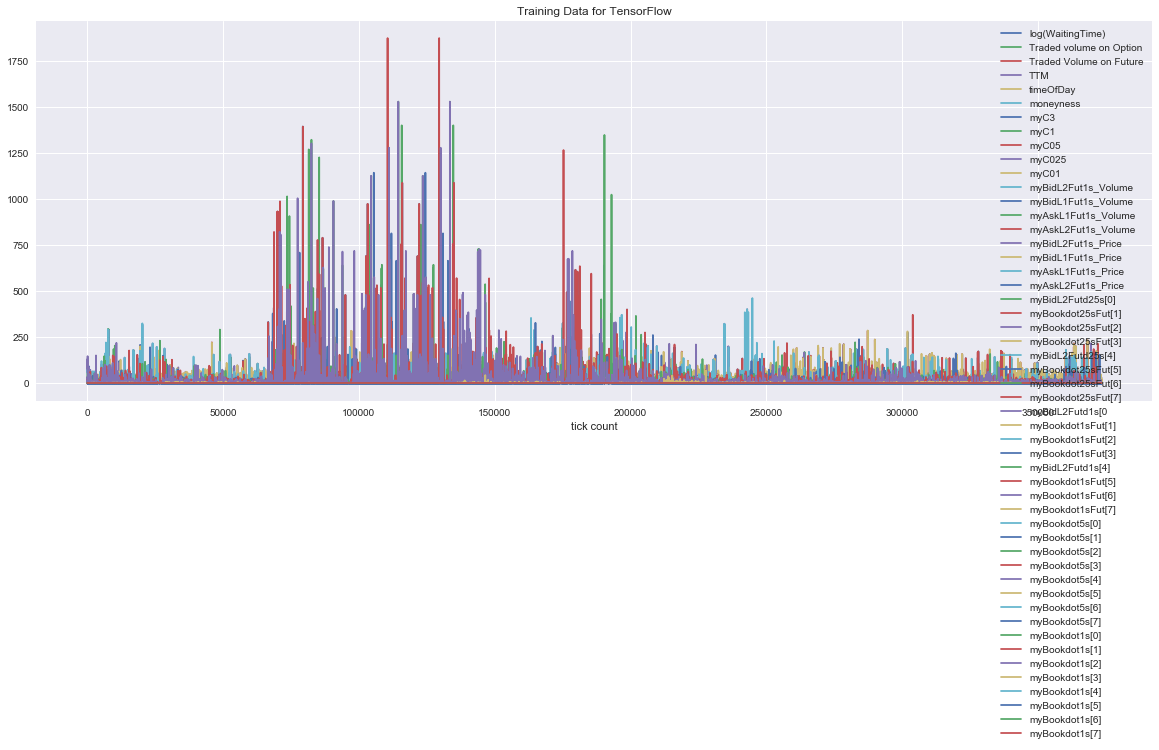

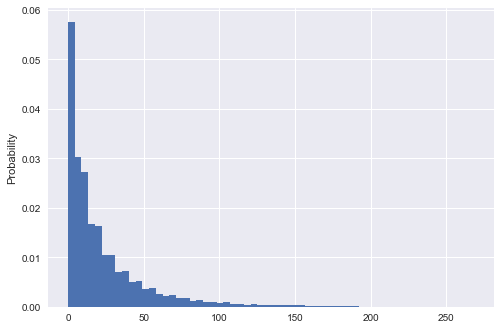

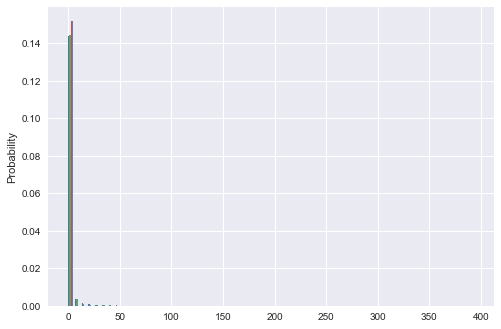

In [35]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','TTM', 'timeOfDay', 'moneyness',\
            'myC3', 'myC1', 'myC05', 'myC025', 'myC01',\
            'myBidL2Fut1s_Volume','myBidL1Fut1s_Volume','myAskL1Fut1s_Volume','myAskL2Fut1s_Volume',\
            'myBidL2Fut1s_Price','myBidL1Fut1s_Price','myAskL1Fut1s_Price','myAskL2Fut1s_Price',\
            'myBidL2Futd25s[0]','myBookdot25sFut[1]','myBookdot25sFut[2]','myBookdot25sFut[3]',\
            'myBidL2Futd25s[4]','myBookdot25sFut[5]','myBookdot25sFut[6]','myBookdot25sFut[7]',\
            'myBidL2Futd1s[0','myBookdot1sFut[1]','myBookdot1sFut[2]','myBookdot1sFut[3]',\
            'myBidL2Futd1s[4]','myBookdot1sFut[5]','myBookdot1sFut[6]','myBookdot1sFut[7]',\
            'myBookdot5s[0]','myBookdot5s[1]','myBookdot5s[2]','myBookdot5s[3]',\
            'myBookdot5s[4]','myBookdot5s[5]','myBookdot5s[6]','myBookdot5s[7]',\
            'myBookdot1s[0]','myBookdot1s[1]','myBookdot1s[2]','myBookdot1s[3]',\
            'myBookdot1s[4]','myBookdot1s[5]','myBookdot1s[6]','myBookdot1s[7]'])
plt.xlabel('tick count')
plt.show()

plt.hist(target, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

plt.hist(targetBook, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

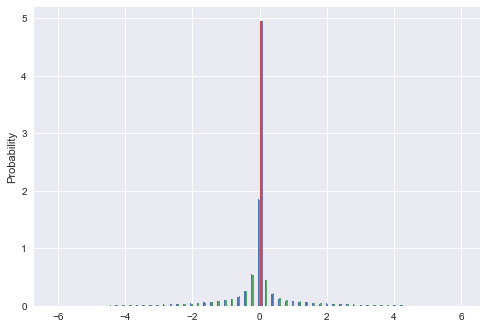

In [36]:
#should we log:
plt.hist(np.log(targetBook+1), normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

In [37]:

train_size = 0.9

#this is for, if we wanted to condition on time
# train_cnt = int(WaitingTimeAndTrade.shape[0] * train_size)
# x_train = WaitingTimeAndTrade[0:train_cnt]
# y_train = target[0:train_cnt]
# x_test = WaitingTimeAndTrade[train_cnt:]
# y_test = target[train_cnt:]


#normalization : not so important because of batch norm but doesn't create any issue
Xmean = WaitingTimeAndTrade.mean()
Xstd = WaitingTimeAndTrade.std()
WaitingTimeAndTrade = (WaitingTimeAndTrade - Xmean)/Xstd

targetBook_Mean = targetBook.mean()
targetBook_std = targetBook.std()

targetBook = (targetBook-targetBook_Mean)/targetBook_std
targetBook_TrueTest = (targetBook_TrueTest-targetBook_Mean)/targetBook_std

# # Y Normalization : could speed up training but we loose the simple loss meaning
# Ymean = target.mean()
# Ystd = target.std()
# target = (target - Ymean)/Ystd


#shuffle the array ahead of time:
#unconditional of time:
#we need to shuffle both arrays similarly, let's not use the train/test from sklearn

myIndices = np.arange(len(WaitingTimeAndTrade))
np.random.shuffle(myIndices)
myIndicesForTrain = myIndices[0:int(train_size*len(myIndices))]
myIndicesForTest = myIndices[int(train_size*len(myIndices)):]




In [38]:
WaitingTimeAndTrade_TrueTest = (WaitingTimeAndTrade_TrueTest - Xmean)/Xstd

In [32]:
whos

Variable                       Type        Data/Info
----------------------------------------------------
CONTRACTTYPE                   EnumMeta    <enum 'CONTRACTTYPE'>
Enum                           EnumMeta    <enum 'Enum'>
Image                          type        <class 'IPython.core.display.Image'>
Path                           type        <class 'pathlib.Path'>
ThreadPool                     function    <function Pool at 0x0000024001AE5AE8>
WaitingTimeAndTrade            ndarray     373398x51: 19043298 elems, type `float64`, 152346384 bytes (145.28883361816406 Mb)
WaitingTimeAndTrade_TrueTest   ndarray     140875x51: 7184625 elems, type `float64`, 57477000 bytes (54.81433868408203 Mb)
Xmean                          float64     1.7127202858249813
Xstd                           float64     8.241526481026165
backupFiles                    function    <function backupFiles at 0x0000024001AEF730>
calendar                       module      <module 'calendar' from '<...>onda3\\lib\\

# TF

In [39]:
import tensorflow as tf

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
import tensorflow as tf
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.reset_default_graph()

# important, do we sub-train

In [41]:
# = removing TTM and TimeOfDay and train these variables as transfer
SUBTRAIN = True
SHUFFLE = False

In [42]:
if SUBTRAIN: #idx 3: TTM, 4:TimeOfDay
    WaitingTimeAndTrade = np.delete(np.delete(WaitingTimeAndTrade, 4, 1),3,1)
    WaitingTimeAndTrade_TrueTest = np.delete(np.delete(WaitingTimeAndTrade_TrueTest, 4, 1),3,1)
if SHUFFLE:
    x_train = WaitingTimeAndTrade[myIndicesForTrain]
    y_train = target[myIndicesForTrain]
    x_test = WaitingTimeAndTrade[myIndicesForTest]
    y_test = target[myIndicesForTest]
    yBook_train = targetBook[myIndicesForTrain]
    yBook_test = target_TrueTest[myIndicesForTest]
else:
    x_train = WaitingTimeAndTrade[:int(train_size *len(WaitingTimeAndTrade))]
    y_train = target[:int(train_size *len(target))]
    x_test = WaitingTimeAndTrade[int(train_size *len(WaitingTimeAndTrade)):]
    y_test = target[int(train_size *len(target)):]
    yBook_train = targetBook[int(train_size *len(targetBook)):]
    yBook_test = target_TrueTest[:int(train_size *len(target_TrueTest))]


del WaitingTimeAndTrade
del target    

In [43]:
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75, allow_growth = True)

In [44]:
# Small epsilon value for the BN transform
epsilon = 1e-3
decay = 0.995
n_hidden_1 = 40
n_hidden_2 = 30
n_hidden_3 = 20
n_hidden_4 = 0
n_input = x_train.shape[1]

training_epochs = 10000
display_step = 100
batch_size = 10000

In [45]:

def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

def batch_norm_wrapper(inputs, n_layer , is_training):

    if is_training is not None:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean[n_layer] ,
                               pop_mean[n_layer] * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var[n_layer] ,
                              pop_var[n_layer] * decay + batch_var * (1 - decay))
        
        with tf.control_dependencies([train_mean, train_var]):
            return gammas[n_layer] * (inputs - batch_mean)/tf.sqrt(batch_var + epsilon)\
                    + biases[n_layer]
    else:
        return gammas[n_layer] * (inputs - pop_mean[n_layer])/tf.sqrt(pop_var[n__layer] + epsilon)\
                + biases[n_layer]

def multilayer_perceptron(x, weights, biases, isTraining):
    #without batch norm:
#     layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
#     layer_1 = tf.nn.leaky_relu(layer_1)
#     layer_1 = tf.nn.dropout(layer_1, keep_prob)
#     out_layer = tf.matmul(layer_1, weights['out']) + biases['out']

    
    #with batch norm, no bias:
    #why isn't the added noise an issue to learn ?
    if isTraining is not None:
        layer_1 = tf.matmul(gaussian_noise_layer(x,0.002), weights['1'])
    else:
        layer_1 = tf.matmul(x, weights['1'])
    
    
    # Calculate batch mean and variance
#     batch_mean1, batch_var1 = tf.nn.moments(layer_1,[0])
    #original paper and Ian Goodfellow :
#     layer_1 = (layer_1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
#     layer_1 = gammas['g1'] * layer_1 + biases['b1']
    #learn scaler and bias as parameters
    
    layer_1 = batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
    layer_1 = tf.nn.leaky_relu(layer_1)
    #recent comment from François Chollet recommand BN after activation:
    #https://github.com/keras-team/keras/issues/1802#issuecomment-187966878
#     tf.stack([x, tf.square(x)], axis=1)


#     #Residual net:
#     # Get the number of rows in the fed value at run-time.
#     layer1_num_rows = tf.shape(layer_1)[0]

#     # Makes a `rows x 2` matrix, by tiling `x` along the row dimension.
#     x_tiled = tf.tile(x, tf.stack([layer1_num_rows, 1]))
#     layer_1 = tf.concat([layer_1, x_tiled], axis = 0)

#     dim = tf.shape(x)[0]
# #     y1 = tf.expand_dims(x, axis = 1)
#     y1 = tf.tile(x, [dim, 1])
#     layer_1 = tf.concat((layer_1, y1), axis = 1)
    
    if isTraining is not None:
        layer_1 = tf.nn.dropout(layer_1, 0.7)
    else:
        layer_1 = tf.nn.dropout(layer_1, 1)
        
    
    #dropout
#     layer_1 = tf.nn.dropout(layer_1, keep_prob)

       
    #create second layer:
    layer_2 = tf.matmul(layer_1, weights['2'])
    layer_2 = tf.nn.leaky_relu(layer_2)
    layer_2 = batch_norm_wrapper(layer_2,'2', isTraining)
#     layer_2 = tf.nn.dropout(layer_2, keep_prob)
    
    #create third layer:
    layer_3 = tf.matmul(layer_2, weights['3'])
    layer_3 = tf.nn.leaky_relu(layer_3)
    layer_3 = batch_norm_wrapper(layer_3,'3', isTraining)    
    
    if isTraining is not None:
        layer_3 = tf.nn.dropout(layer_3, 0.7)
    else:
        layer_3 = tf.nn.dropout(layer_3, 1)
    
    if(n_hidden_4>0):
        #create fourth layer:
        layer_4 = tf.matmul(layer_3, weights['4'])
        layer_4 = tf.nn.leaky_relu(layer_4)   
    else: 
        layer_4=layer_3
        
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    if isTraining is not None:
        out_layer = gaussian_noise_layer(out_layer,0.005)

    return out_layer


#I keep it this way to have a lower level implementation (just for me, not so useful nor performant)

#xavier initialization modified to take into account the no symmetric leaky relu:
#we would multiply by sqrt(2) with relu, lrelu will have a slope on the negative values, which is by default .2
#se we multiply by sqrt(2/1.2) = sqrt(1.67)
weights = {
    '1': tf.Variable(tf.random_normal([n_input, n_hidden_1], mean=0, stddev=tf.sqrt(2*1.67/(n_input+n_hidden_1))), name='w1'),
    '2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_1+n_hidden_2))), name='w2'),
    '3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_2+n_hidden_3))), name='w3'),
#     '4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4)))),
    'out': tf.Variable(tf.random_normal([n_hidden_3, 1], mean=0, stddev=tf.sqrt(2*1.67/(1+n_hidden_3))), name = 'wout')
}

gammas = {
    '1': tf.Variable(tf.ones([n_hidden_1]), name = 'g1'), #no scale for output, start at 1
    '2': tf.Variable(tf.ones([n_hidden_2]), name = 'g2'),
    '3': tf.Variable(tf.ones([n_hidden_3]), name = 'g3')
#     '4': tf.Variable(tf.ones([n_hidden_4]))
}

#common to initialize biases at 0
biases = {
    '1': tf.Variable(tf.zeros([n_hidden_1]), name = 'b1'),
    '2': tf.Variable(tf.zeros([n_hidden_2]), name = 'b2'),
    '3': tf.Variable(tf.zeros([n_hidden_3]), name = 'b3'),
    'out': tf.Variable(tf.zeros([1]), name = 'bout') #keep bias for output
}

pop_mean = {
    '1' : tf.Variable(tf.zeros([n_hidden_1]), name = 'pm1', trainable=False), #size depends if after or before relu 
    '2' : tf.Variable(tf.zeros([n_hidden_2]), name = 'pm2', trainable=False),
    '3' : tf.Variable(tf.zeros([n_hidden_3]), name = 'pm3', trainable=False)
}

pop_var = {
    '1' : tf.Variable(tf.ones([n_hidden_1]), name = 'pv1', trainable=False),
    '2' : tf.Variable(tf.ones([n_hidden_2]), name = 'pv2', trainable=False),
    '3' : tf.Variable(tf.ones([n_hidden_3]), name = 'pv3', trainable=False)
}


# writeup = tf.Variable(tf.ones([10,  n_input]))
# keep_prob = tf.placeholder("float")
isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining")
L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization")
L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization")

x = tf.placeholder("float", [None, n_input], name="inputs")
y = tf.placeholder("float", [None, 1], name="TrueLabel")

In [16]:
# Define savers for explicit subsets of the variables.
weights_saver = tf.train.Saver(var_list=weights)
biases_saver = tf.train.Saver(var_list=biases)
gammas_saver = tf.train.Saver(var_list = gammas)
pop_mean_saver = tf.train.Saver(var_list = pop_mean)
pop_var_saver = tf.train.Saver(var_list = pop_var)

In [17]:


predictions = multilayer_perceptron(x, weights, biases, isTraining)

#if regularizing
regularizersL1 = tf.reduce_mean(tf.square(weights['3'])) #+ tf.reduce_mean(tf.square(weights['4']))
regularizersL2 =  tf.reduce_mean(tf.abs(weights['3'])) #+ tf.reduce_mean(tf.abs(weights['4'])) 

absCost = tf.reduce_mean(tf.abs(predictions - y)) 
cost = tf.reduce_mean(tf.square(predictions - y)) 

regLoss = cost + L2Regularization * regularizersL1 + L1Regularization*regularizersL2
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(regLoss)


In [18]:
# if unshuffled beforehand or if want to add randomness to avoid overfitting batches
def next_batch(xdata,ydata,batch_size,normalize=False):
    #complete random batching + normalization
    
    nbLabels = xdata.shape[1]
    # Grab a random starting point for each batch
    rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

#     if normalize:
         #not yet implemented
        
    return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size



# def next_batch(xdata,ydata,batch_size,i,normalize=False):
#     #complete random batching + normalization
    
#     # Grab a random starting point for each batch
# #     rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

# #     if normalize:
#          #not yet implemented
        
#     return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size

In [19]:


with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(x_train) / batch_size)
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
#         
#         x_batches = np.array_split(x_train, total_batch)
#         y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            batch_x, batch_y = next_batch(x_train, y_train, batch_size,i)
            _, c = sess.run([optimizer, absCost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                isTraining: True,
                                L1Regularization:0.000,
                                L2Regularization:0.0000
                            })
            
            avg_cost += c / total_batch
            
        if epoch % display_step == 0:
            tc = sess.run(absCost, feed_dict={
                                x: x_test, 
                                y: y_test, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })
            true_tc=  \
            sess.run(absCost, feed_dict={
                                x: WaitingTimeAndTrade_TrueTest, 
                                y: target_TrueTest, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })
            print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                "{:.4f}".format(avg_cost), "test cost=", \
                "{:.4f}".format(tc),"true test cost=", \
                "{:.4f}".format(true_tc))
            print(sess.run(weights['1']))
            weights_saver.save(sess, './savedModels/unconditionTick/Weights/weights')
            biases_saver.save(sess, './savedModels/unconditionTick/Biases/biases')
            gammas_saver.save(sess, './savedModels/unconditionTick/Gammas/gammas')
            pop_mean_saver.save(sess, './savedModels/unconditionTick/Pop_mean/pop_mean')
            pop_var_saver.save(sess, './savedModels/unconditionTick/Pop_var/pop_var')
    print("Optimization Finished!")

Epoch: 0001 train cost= 24.9877 test cost= 15.5665 true test cost= 22.5880
[[ 0.34448442  0.21438695  0.19586341 -0.28778896 -0.19931239  0.19121024
   0.01223267 -0.13428774  0.04055172  0.18588802 -0.2961113   0.09727047
  -0.05408837  0.2932128   0.04608383 -0.18508518 -0.05336408 -0.09377297
  -0.26452604  0.55232155  0.40681902 -0.17404544 -0.11215455 -0.07822704
  -0.13885455  0.03364569  0.2132154   0.14149833  0.1636138   0.20071222
   0.3861161  -0.03360134 -0.3337967  -0.06003313  0.16461284  0.56164664
   0.06094868 -0.01383131 -0.0843784   0.00590451]
 [ 0.23593508 -0.13358663  0.5898235   0.2319859   0.10996152  0.18524998
   0.06205598 -0.1460219  -0.04629572 -0.48617092 -0.01778555  0.08652505
   0.25287926  0.15109551  0.34586492  0.22068456  0.14845665  0.4198697
  -0.10692501 -0.43272996 -0.20008588 -0.1258869   0.36745146  0.24950556
   0.11698699 -0.11396609  0.41723627 -0.13686933  0.45606613 -0.03171796
   0.02654531 -0.10612265  0.10226068  0.00966541  0.0828527 

Epoch: 0201 train cost= 24.6452 test cost= 15.1556 true test cost= 22.2806
[[ 0.34095657  0.16115168  0.24251926 -0.33320314 -0.2484687   0.14305943
  -0.03482237 -0.08738796  0.08973728  0.1325336  -0.24542469  0.09834477
  -0.01692292  0.3074476   0.00557999 -0.2342952  -0.00114677 -0.04482237
  -0.3068583   0.5833181   0.34591848 -0.21509568 -0.07895645 -0.05786206
  -0.18408322  0.03958056  0.15788409  0.08912046  0.11591505  0.14580084
   0.4343875  -0.01992333 -0.3841352   0.00231366  0.15339905  0.60261834
   0.0852925   0.03729061 -0.0535851   0.05185338]
 [ 0.2705239  -0.09618138  0.6208619   0.1927321   0.11496005  0.14248754
   0.03099036 -0.10057327 -0.02232334 -0.43011546  0.01494585  0.09454502
   0.20157601  0.16308738  0.29542133  0.19129789  0.13892514  0.39902356
  -0.15474601 -0.42845127 -0.17667311 -0.0853863   0.37675092  0.26363385
   0.08553123 -0.06572641  0.3990306  -0.16493507  0.40925455  0.00726748
   0.03071417 -0.11803433  0.11464578  0.04967668  0.0917092

Epoch: 0401 train cost= 24.1191 test cost= 14.7697 true test cost= 21.8986
[[ 0.28923008  0.11091051  0.2864195  -0.37497976 -0.2912023   0.09561008
  -0.07803597 -0.04472337  0.14562273  0.08782009 -0.20209591  0.15730341
   0.03555859  0.36139184 -0.04511005 -0.2846027   0.04773805  0.00672939
  -0.34474173  0.6375551   0.33188504 -0.18036467 -0.02301178 -0.11073911
  -0.23455738  0.07307713  0.11072523  0.04474176  0.07219252  0.09416375
   0.47687227  0.03455148 -0.42955878  0.05531092  0.21239786  0.6483974
   0.03950884  0.08374075 -0.10393061  0.0910055 ]
 [ 0.27736276 -0.05274335  0.57952106  0.17506221  0.10122251  0.12403087
   0.05011835 -0.10322237 -0.01923687 -0.39672038  0.04494312  0.04688308
   0.15796538  0.11526318  0.28586227  0.15547661  0.10525059  0.34788862
  -0.15791641 -0.4553836  -0.15583469 -0.10406934  0.32498705  0.25088763
   0.10202136 -0.03069352  0.3554748  -0.13599531  0.38443813  0.05168452
   0.01177043 -0.15609342  0.10869464  0.03996397  0.04685606

KeyboardInterrupt: 

In [21]:
tf.reset_default_graph()

In [32]:
#is it worst than constant value, i.e. stupid benchmark?
print(np.mean(np.abs(target_TrueTest-14)))
print(np.mean(np.abs(y_test-8)))


16.14221326183791
12.609324601700713


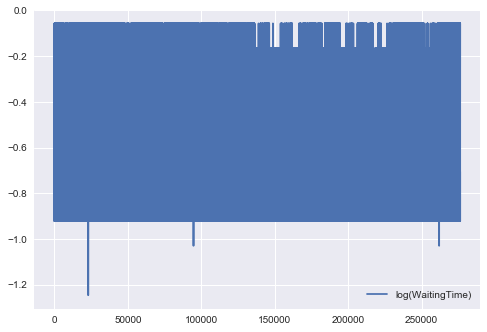

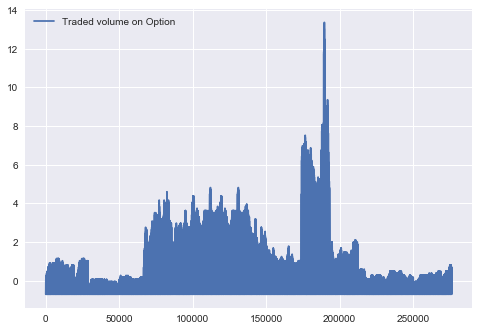

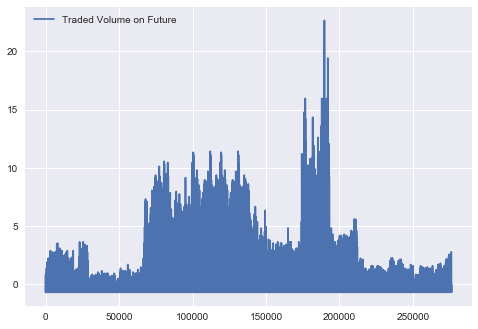

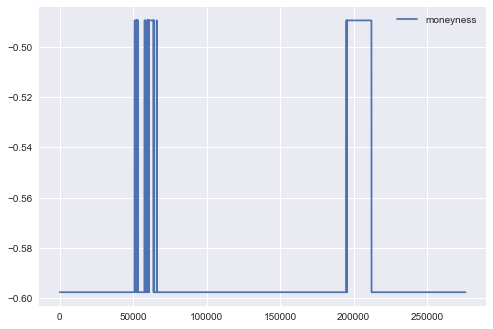

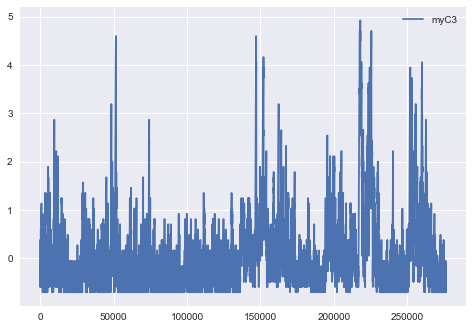

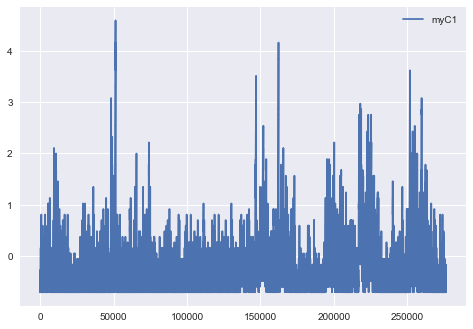

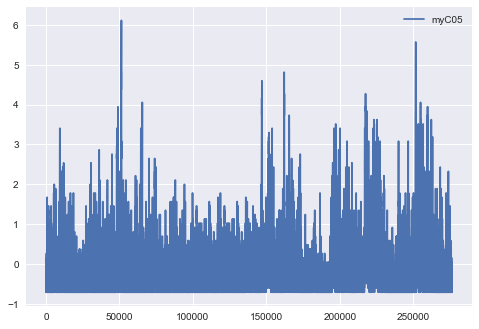

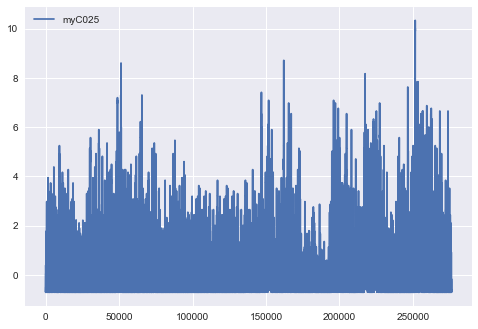

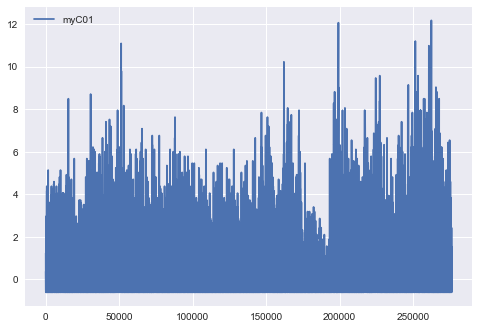

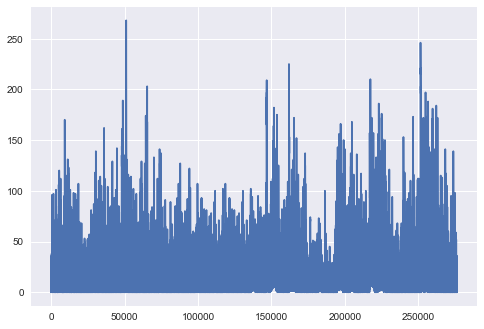

In [33]:
myCol = ['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','moneyness', 'myC3', 'myC1', 'myC05', 'myC025', 'myC01']
for i in range(x_train.shape[1]):
    plt.plot(x_train[:,i], label = myCol[i] )
    plt.legend()
    plt.show()
plt.plot(y_train)
plt.show()

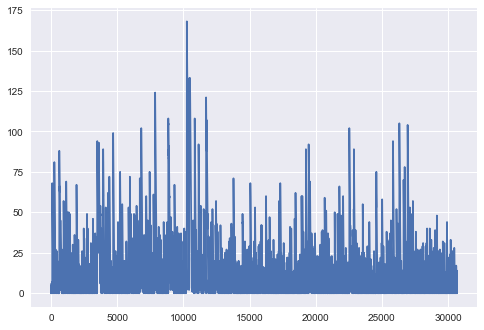

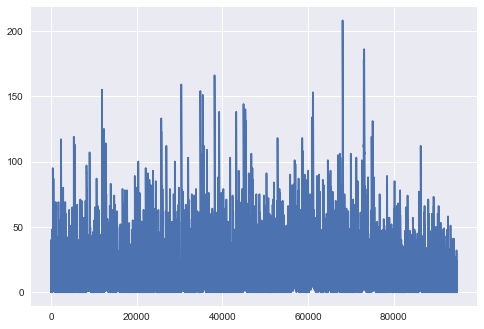

In [34]:
plt.plot(y_test)
plt.show()
plt.plot(target_TrueTest)
plt.show()

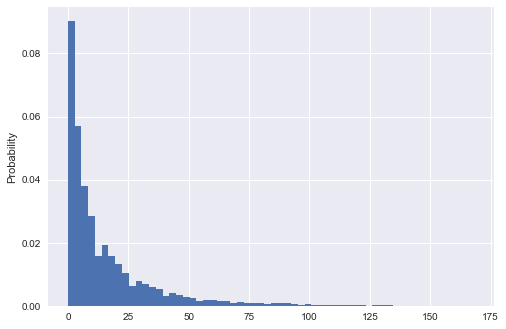

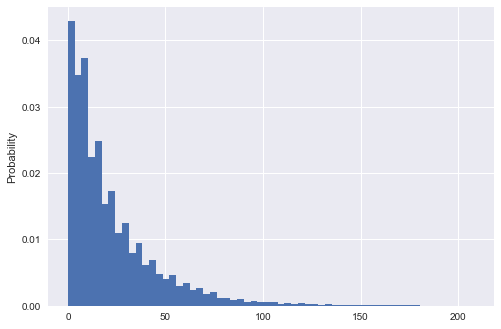

In [35]:
plt.hist(y_test, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()
plt.hist(target_TrueTest, normed=True, bins=60)
plt.ylabel('Probability')

plt.show()

# Benchmark the neuron with a simpler model from sklearn, am I still overfitting the test set ? How come !!


In [36]:
from sklearn.metrics import mean_absolute_error

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
myModel_backtest1 = RandomForestRegressor(n_estimators = 30, n_jobs=3, max_depth=4)
myModel_backtest1.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest1.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest1.predict(WaitingTimeAndTrade_TrueTest)))

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


15.280296909644008 14.0771131616525


In [39]:
from sklearn.linear_model import ElasticNet

In [40]:
myModel_backtest2 = ElasticNet()
myModel_backtest2.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest2.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest2.predict(WaitingTimeAndTrade_TrueTest)))

15.921240449215723 13.34899796287136


In [41]:
from sklearn.neural_network import MLPRegressor

In [42]:
myModel_backtest3 = MLPRegressor(hidden_layer_sizes=(30,10,5))
myModel_backtest3.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest3.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest3.predict(WaitingTimeAndTrade_TrueTest)))

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


14.364561073584563 13.716583150106018


# now conditional

In [52]:
tf.reset_default_graph()

In [53]:
pathsToVariables = "./savedModels/unconditionTick/"

In [54]:
n_hidden_4 = 10

def initializeVariables_condi(sess):
    
    global weights, gammas, biases, pop_mean, pop_var, isTraining, L1Regularization, L2Regularization, x, y
        
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Weights/weights.meta')
    new_saver.restore(sess, pathsToVariables + 'Weights/weights')

    
    weights = {
        '1': tf.Variable(sess.graph.get_tensor_by_name("w1:0"), name='w1', trainable=False),
        '2': tf.Variable(sess.graph.get_tensor_by_name("w2:0"), name='w2', trainable=False),
        '3': tf.Variable(sess.graph.get_tensor_by_name("w3:0"), name='w3', trainable=False),
        '4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4))), name='w4'),
        'out': tf.Variable(tf.random_normal([n_hidden_4, 1], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4))), name='wout')
    }
    
        
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Gammas/gammas.meta')
    new_saver.restore(sess, pathsToVariables + 'Gammas/gammas')

    
    gammas = {
        '1': tf.Variable(sess.graph.get_tensor_by_name("g1:0"), name = 'g1', trainable=False), #no scale for output, start at 1
        '2': tf.Variable(sess.graph.get_tensor_by_name("g2:0"), name = 'g2', trainable=False),
        '3': tf.Variable(sess.graph.get_tensor_by_name("g3:0"), name = 'g3', trainable=False),
        '4': tf.Variable(tf.ones([n_hidden_4]), name = 'g4')
    #     '4': tf.Variable(tf.ones([n_hidden_4]))
    }

        
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Biases/biases.meta')
    new_saver.restore(sess, pathsToVariables + 'Biases/biases')
    
    #common to initialize biases at 0
    biases = {
        '1': tf.Variable(sess.graph.get_tensor_by_name("b1:0"), name = 'b1', trainable=False),
        '2': tf.Variable(sess.graph.get_tensor_by_name("b2:0"), name = 'b2', trainable=False),
        '3': tf.Variable(sess.graph.get_tensor_by_name("b3:0"), name = 'b3', trainable=False),
        '4': tf.Variable(tf.zeros([n_hidden_4]), name = 'b4'),
        'out': tf.Variable(tf.zeros([1]), name = 'bout') #keep bias for output
    }
    
        
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Pop_mean/pop_mean.meta')
    new_saver.restore(sess, pathsToVariables + 'Pop_mean/pop_mean')


    pop_mean = {
        '1' : tf.Variable(sess.graph.get_tensor_by_name("pm1:0"), name = 'pm1', trainable=False), #size depends if after or before relu 
        '2' : tf.Variable(sess.graph.get_tensor_by_name("pm2:0"), name = 'pm2', trainable=False),
        '3' : tf.Variable(sess.graph.get_tensor_by_name("pm3:0"), name = 'pm3', trainable=False),
        '4' : tf.Variable(tf.zeros([n_hidden_4]), name = 'pm4'),
    }

        
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Pop_var/pop_var.meta')
    new_saver.restore(sess, pathsToVariables + 'Pop_var/pop_var')
    
    pop_var = {
        '1' : tf.Variable(sess.graph.get_tensor_by_name("pv1:0"), name = 'pv1', trainable=False),
        '2' : tf.Variable(sess.graph.get_tensor_by_name("pv2:0"), name = 'pv2', trainable=False),
        '3' : tf.Variable(sess.graph.get_tensor_by_name("pv3:0"), name = 'pv3', trainable=False),
        '4' : tf.Variable(tf.ones([n_hidden_4]), name = 'pv4')
    }


    # writeup = tf.Variable(tf.ones([10,  n_input]))
    # keep_prob = tf.placeholder("float")
    isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining")
    L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization")
    L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization")

    x = tf.placeholder("float", [None, n_input], name="inputs")
    y = tf.placeholder("float", [None, 1], name="TrueLabel")

In [55]:
def multilayer_perceptron_conditional(x, weights, biases, isTraining):


    
    #with batch norm, no bias:
    #why isn't the added noise an issue to learn ?
    if isTraining is not None:
        layer_1 = tf.matmul(gaussian_noise_layer(x,0.002), weights['1'])
    else:
        layer_1 = tf.matmul(x, weights['1'])
    

    layer_1 = batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
    layer_1 = tf.nn.leaky_relu(layer_1)

    
    if isTraining is not None:
        layer_1 = tf.nn.dropout(layer_1, 0.7)
    else:
        layer_1 = tf.nn.dropout(layer_1, 1)
        

       
    #create second layer:
    layer_2 = tf.matmul(layer_1, weights['2'])
    layer_2 = tf.nn.leaky_relu(layer_2)
    layer_2 = batch_norm_wrapper(layer_2,'2', isTraining)
    
    #create third layer:
    layer_3 = tf.matmul(layer_2, weights['3'])
    layer_3 = tf.nn.leaky_relu(layer_3)
    layer_3 = batch_norm_wrapper(layer_3,'3', isTraining)    
    
    if isTraining is not None:
        layer_3 = tf.nn.dropout(layer_3, 0.7)
    else:
        layer_3 = tf.nn.dropout(layer_3, 1)


    layer_4 = tf.matmul(layer_3, weights['4'])
    layer_4 = tf.nn.leaky_relu(layer_4)   
    layer_4 = batch_norm_wrapper(layer_4,'4', isTraining)
        
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    if isTraining is not None:
        out_layer = gaussian_noise_layer(out_layer,0.005)

    return out_layer

In [63]:
#test if we can get values from past thing, maybe that's why it's so slow

del weights
#let's test if variables are erased:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
#     summary_writer = tf.summary.FileWriter('/tmp/logs', sess.graph_def)
            
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Weights/weights.meta')
    new_saver.restore(sess, pathsToVariables + 'Weights/weights')
#     sess.run(tf.global_variables_initializer())
    weights = {
        '1': tf.Variable(tf.get_default_graph().get_tensor_by_name("w1:0"), name='w1', trainable=False),
        '2': tf.Variable(tf.get_default_graph().get_tensor_by_name("w2:0"), name='w2', trainable=False),
        '3': tf.Variable(tf.get_default_graph().get_tensor_by_name("w3:0"), name='w3', trainable=False),
        '4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4))), name='w4'),
        'out': tf.Variable(tf.random_normal([n_hidden_4, 1], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4))), name='wout')
    }
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.local_variables_initializer())
    init_new_vars_op = tf.initialize_variables([weights['4'] , weights['out']])
    sess.run(init_new_vars_op)
#     filter_summary = tf.summary.histogram('w',weights['1'])
    print(sess.run(weights['1']))
#     summary_writer.add_summary(filter_summary, 0).eval()    
    new_saver = tf.train.import_meta_graph(pathsToVariables + 'Gammas/gammas.meta')
    new_saver.restore(sess, pathsToVariables + 'Gammas/gammas')
    gammas = {
        '1': tf.Variable(sess.graph.get_tensor_by_name("g1:0"), name = 'g1', trainable=False), #no scale for output, start at 1
        '2': tf.Variable(sess.graph.get_tensor_by_name("g2:0"), name = 'g2', trainable=False),
        '3': tf.Variable(sess.graph.get_tensor_by_name("g3:0"), name = 'g3', trainable=False),
        '4': tf.Variable(tf.ones([n_hidden_4]), name = 'g4')
    #     '4': tf.Variable(tf.ones([n_hidden_4]))
    }
    print(sess.run(weights['1']))
    init_new_vars_op = tf.initialize_variables([weights['4'] , weights['out']])
    sess.run(init_new_vars_op)
    print('new ini')
    print(sess.run(weights['1']))
#     summary_writer.add_summary(filter_summary, 1).eval()

INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Weights/weights


FailedPreconditionError: Attempting to use uninitialized value w1_12
	 [[Node: w1_12/_8 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_w1_12", _device="/job:localhost/replica:0/task:0/device:GPU:0"](w1_12)]]
	 [[Node: w1_12/_9 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4_w1_12", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [47]:
with tf.Session() as sess:
    
    #initialize variables from past unconditional training
    initializeVariables_condi()
    #if regularizing
    
    predictions = multilayer_perceptron_conditional(x, weights, biases, isTraining)
    regularizersL1 = tf.reduce_mean(tf.square(weights['3'])) + tf.reduce_mean(tf.square(weights['4']))
    regularizersL2 =  tf.reduce_mean(tf.abs(weights['3'])) + tf.reduce_mean(tf.abs(weights['4'])) 

    absCost = tf.reduce_mean(tf.abs(predictions - y)) 
    cost = tf.reduce_mean(tf.square(predictions - y)) 

    regLoss = cost + L2Regularization * regularizersL1 + L1Regularization*regularizersL2
    optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(regLoss)
    
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(x_train) / batch_size)
    
    print('start training with '+str(total_batch)+' batches')
    for epoch in range(training_epochs):
        avg_cost = 0.0
#         
#         x_batches = np.array_split(x_train, total_batch)
#         y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            batch_x, batch_y = next_batch(x_train, y_train, batch_size,i)
            _, c = sess.run([optimizer, absCost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                isTraining: True,
                                L1Regularization:0.000,
                                L2Regularization:0.0000
                            })
            
            avg_cost += c / total_batch
            
        if epoch % display_step == 0:
            tc = sess.run(absCost, feed_dict={
                                x: x_test, 
                                y: y_test, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })

INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Weights/weights
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Gammas/gammas
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Biases/biases
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Pop_mean/pop_mean
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Pop_var/pop_var
start training with 27 batches


KeyboardInterrupt: 

# Book prediction

Easy, just rewrite the data conditioner to get out the same data + other interesting and as y, the first level volumes and prices.

# Data Conditioner

See above

In [493]:
SUBTRAIN = True
SHUFFLE = False

if SUBTRAIN: #idx 3: TTM, 4:TimeOfDay
    WaitingTimeAndTrade = np.delete(np.delete(WaitingTimeAndTrade, 4, 1),3,1)
    WaitingTimeAndTrade_TrueTest = np.delete(np.delete(WaitingTimeAndTrade_TrueTest, 4, 1),3,1)
if SHUFFLE:
    x_train = WaitingTimeAndTrade[myIndicesForTrain]
    y_train = targetBook[myIndicesForTrain]
    x_test = WaitingTimeAndTrade[myIndicesForTest]
    y_test = targetBook[myIndicesForTest]
else:
    x_train = WaitingTimeAndTrade[:int(train_size *len(WaitingTimeAndTrade))]
    y_train = targetBook[:int(train_size *len(target))]
    x_test = WaitingTimeAndTrade[int(train_size *len(WaitingTimeAndTrade)):]
    y_test = targetBook[int(train_size *len(target)):]


del WaitingTimeAndTrade
del target   

In [494]:
# Small epsilon value for the BN transform
epsilon = 1e-3
decay = 0.995
n_hidden_1 = 40
n_hidden_2 = 30
n_hidden_3 = 20
n_hidden_4 = 0
n_input = x_train.shape[1]

training_epochs = 10000
display_step = 100
batch_size = 10000
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

def batch_norm_wrapper(inputs, n_layer , is_training):

    if is_training is not None:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean[n_layer] ,
                               pop_mean[n_layer] * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var[n_layer] ,
                              pop_var[n_layer] * decay + batch_var * (1 - decay))
        
        with tf.control_dependencies([train_mean, train_var]):
            return gammas[n_layer] * (inputs - batch_mean)/tf.sqrt(batch_var + epsilon)\
                    + biases[n_layer]
    else:
        return gammas[n_layer] * (inputs - pop_mean[n_layer])/tf.sqrt(pop_var[n__layer] + epsilon)\
                + biases[n_layer]


In [495]:
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75, allow_growth = True)

In [496]:
weights = {
    '1': tf.Variable(tf.random_normal([n_input, n_hidden_1], mean=0, stddev=tf.sqrt(2*1.67/(n_input+n_hidden_1))), name='w1'),
    '2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_1+n_hidden_2))), name='w2'),
    '3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_2+n_hidden_3))), name='w3'),
#     '4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4)))),
    'out': tf.Variable(tf.random_normal([n_hidden_3, 4], mean=0, stddev=tf.sqrt(2*1.67/(1+n_hidden_3))), name = 'wout')
}

gammas = {
    '1': tf.Variable(tf.ones([n_hidden_1]), name = 'g1'), #no scale for output, start at 1
    '2': tf.Variable(tf.ones([n_hidden_2]), name = 'g2'),
    '3': tf.Variable(tf.ones([n_hidden_3]), name = 'g3')
#     '4': tf.Variable(tf.ones([n_hidden_4]))
}

#common to initialize biases at 0
biases = {
    '1': tf.Variable(tf.zeros([n_hidden_1]), name = 'b1'),
    '2': tf.Variable(tf.zeros([n_hidden_2]), name = 'b2'),
    '3': tf.Variable(tf.zeros([n_hidden_3]), name = 'b3'),
    'out': tf.Variable(tf.zeros([4]), name = 'bout') #keep bias for output
}

pop_mean = {
    '1' : tf.Variable(tf.zeros([n_hidden_1]), name = 'pm1', trainable=False), #size depends if after or before relu 
    '2' : tf.Variable(tf.zeros([n_hidden_2]), name = 'pm2', trainable=False),
    '3' : tf.Variable(tf.zeros([n_hidden_3]), name = 'pm3', trainable=False)
}

pop_var = {
    '1' : tf.Variable(tf.ones([n_hidden_1]), name = 'pv1', trainable=False),
    '2' : tf.Variable(tf.ones([n_hidden_2]), name = 'pv2', trainable=False),
    '3' : tf.Variable(tf.ones([n_hidden_3]), name = 'pv3', trainable=False)
}


# writeup = tf.Variable(tf.ones([10,  n_input]))
# keep_prob = tf.placeholder("float")
isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining")
L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization")
L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization")

x = tf.placeholder("float", [None, n_input], name="inputs")
y = tf.placeholder("float", [None, 4], name="TrueLabel")

In [ ]:
# Define savers for explicit subsets of the variables.
weights_saver_book = tf.train.Saver(var_list=weights)
biases_saver_book = tf.train.Saver(var_list=biases)
gammas_saver_book = tf.train.Saver(var_list = gammas)
pop_mean_saver_book = tf.train.Saver(var_list = pop_mean)
pop_var_saver_book = tf.train.Saver(var_list = pop_var)

In [497]:
def multilayer_perceptron_conditional(x, weights, biases, isTraining):


    
    #with batch norm, no bias:
    #why isn't the added noise an issue to learn ?
    if isTraining is not None:
        layer_1 = tf.matmul(gaussian_noise_layer(x,0.002), weights['1'])
    else:
        layer_1 = tf.matmul(x, weights['1'])
    

    layer_1 = batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
    layer_1 = tf.nn.leaky_relu(layer_1)

    
    if isTraining is not None:
        layer_1 = tf.nn.dropout(layer_1, 0.7)
    else:
        layer_1 = tf.nn.dropout(layer_1, 1)
        

       
    #create second layer:
    layer_2 = tf.matmul(layer_1, weights['2'])
    layer_2 = tf.nn.leaky_relu(layer_2)
    layer_2 = batch_norm_wrapper(layer_2,'2', isTraining)
    
    #create third layer:
    layer_3 = tf.matmul(layer_2, weights['3'])
    layer_3 = tf.nn.leaky_relu(layer_3)
    layer_3 = batch_norm_wrapper(layer_3,'3', isTraining)    
    
    if isTraining is not None:
        layer_3 = tf.nn.dropout(layer_3, 0.7)
    else:
        layer_3 = tf.nn.dropout(layer_3, 1)


    layer_4 = tf.matmul(layer_3, weights['4'])
    layer_4 = tf.nn.leaky_relu(layer_4)   
    layer_4 = batch_norm_wrapper(layer_4,'4', isTraining)
        
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    if isTraining is not None:
        out_layer = gaussian_noise_layer(out_layer,0.005)

    return out_layer

In [498]:


predictions = multilayer_perceptron(x, weights, biases, isTraining)

#if regularizing
regularizersL1 = tf.reduce_mean(tf.square(weights['3'])) #+ tf.reduce_mean(tf.square(weights['4']))
regularizersL2 =  tf.reduce_mean(tf.abs(weights['3'])) #+ tf.reduce_mean(tf.abs(weights['4'])) 

absCost = tf.reduce_mean(tf.abs(predictions - y)) 
cost = tf.reduce_mean(tf.square(predictions - y)) 

regLoss = cost + L2Regularization * regularizersL1 + L1Regularization*regularizersL2
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(regLoss)


In [502]:
# if unshuffled beforehand or if want to add randomness to avoid overfitting batches
def next_batch(xdata,ydata,batch_size,normalize=False):
    #complete random batching + normalization
    
    nbLabels = xdata.shape[1]
    # Grab a random starting point for each batch
    rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

#     if normalize:
         #not yet implemented
        
    return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 4) #check input size



with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(x_train) / batch_size)
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
#         
#         x_batches = np.array_split(x_train, total_batch)
#         y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            batch_x, batch_y = next_batch(x_train, y_train, batch_size,i)
            _, c = sess.run([optimizer, absCost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                isTraining: True,
                                L1Regularization:0.000,
                                L2Regularization:0.0000
                            })
            
            avg_cost += c / total_batch
            
        if epoch % display_step == 0:
            tc = sess.run(absCost, feed_dict={
                                x: x_test, 
                                y: y_test, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })
            true_tc=  \
            sess.run(absCost, feed_dict={
                                x: WaitingTimeAndTrade_TrueTest, 
                                y: targetBook_TrueTest, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })
            print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                "{:.4f}".format(avg_cost), "test cost=", \
                "{:.4f}".format(tc),"true test cost=", \
                "{:.4f}".format(true_tc))
#             print(sess.run(weights['1']))
            weights_saver_book.save(sess, './savedModels/unconditionBook/Weights/weights')
            biases_saver_book.save(sess, './savedModels/unconditionBook/Biases/biases')
            gammas_saver_book.save(sess, './savedModels/unconditionBook/Gammas/gammas')
            pop_mean_saver_book.save(sess, './savedModels/unconditionBook/Pop_mean/pop_mean')
            pop_var_saver_book.save(sess, './savedModels/unconditionBook/Pop_var/pop_var')
    print("Optimization Finished!")

Epoch: 0001 train cost= 1.6075 test cost= 1.6346 true test cost= 1.7597
Epoch: 0101 train cost= 1.4190 test cost= 1.4380 true test cost= 1.5668
Epoch: 0201 train cost= 1.3551 test cost= 1.3567 true test cost= 1.4930
Epoch: 0301 train cost= 1.3374 test cost= 1.3178 true test cost= 1.4608
Epoch: 0401 train cost= 1.3369 test cost= 1.3117 true test cost= 1.4608
Epoch: 0501 train cost= 1.3596 test cost= 1.3240 true test cost= 1.4812
Epoch: 0601 train cost= 1.3943 test cost= 1.3520 true test cost= 1.5092
Epoch: 0701 train cost= 1.4443 test cost= 1.3893 true test cost= 1.5457
Epoch: 0801 train cost= 1.4807 test cost= 1.4201 true test cost= 1.5762
Epoch: 0901 train cost= 1.5038 test cost= 1.4399 true test cost= 1.5964
Epoch: 1001 train cost= 1.5002 test cost= 1.4446 true test cost= 1.6018
Epoch: 1101 train cost= 1.4953 test cost= 1.4357 true test cost= 1.5943
Epoch: 1201 train cost= 1.4970 test cost= 1.4261 true test cost= 1.5868
Epoch: 1301 train cost= 1.4735 test cost= 1.4131 true test cost=

KeyboardInterrupt: 

# Conditional Learner/Tester

The idea is that, if I am learning the Tick and Book conditionning on [t;t+x] and testing the book prediction on [t+x;t+x+c]
Am I able to better predict the book ?